## BẢNG PHÂN CÔNG
| MSSV     | Họ và tên        | % đóng góp (tối đa 100%) | Chi   tiết công việc         |
|----------|------------------|--------------------------|------------------------------|
| 19120511 | Võ Văn Hiếu      | 100                      | câu 1,2                      |
| 19120526 | Huỳnh Đức Huy    | 100                      | câu 1,2 + tiền xử lý dữ liệu |
| 19120539 | Vương Thế Khang  | 100                      | câu 5,6                      |
| 19120554 | Lê Kiệt          | 100                      | câu 3,4                      |
| 19120586 | Nguyễn Phát Minh | 100                      | Tiền xử lý dữ liệu           |


## Import các thư viện

In [1]:
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
from underthesea import word_tokenize
from underthesea import sent_tokenize
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# I. Khám phá dữ liệu

(làm tương tự theo `preprocess_outline.png` + `preprocess_ref.ipynb`)

### Đọc dữ liệu từ file csv vào dataframe

In [2]:
news_df = pd.read_csv('vn_news_223_tdlfr.csv')
news_df.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


### Kiểm tra phân bố các lớp/nhãn 
- plot cột `label` thành 2 bar, mỗi bar là freq của 1 hoặc 0

<AxesSubplot:xlabel='label', ylabel='frequency'>

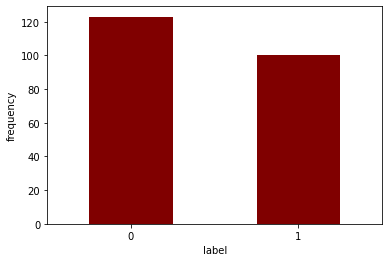

In [3]:
news_df['label'].value_counts().plot.bar(xlabel = 'label', ylabel = 'frequency', rot = 0, color = 'maroon')

### Thông tin thống kê của văn bản
- chiều dài TB mỗi record, ...

In [4]:
print('Chiều dài trung bình của các text:', news_df['text'].apply(len).mean())

Chiều dài trung bình của các text: 2539.7713004484303


# II. Tiền xử lý dữ liệu

Ở phần này, ta tiền xử lý văn bản cho cột `text`. Các bước xử lý:
- Bước 1: loại bỏ các đường dẫn
- Bước 2: loại bỏ ký tự đặc biệt (@,#, /,!.\'+-= và \n)
- Bước 3: tokenize (sử dụng Under The Sea)
- Bước 4: loại bỏ stopwords (Link stopwords: https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt)

In [5]:
# Lấy danh sách stopwords
stopwords_raw_url = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"
stopwords = requests.get(stopwords_raw_url).text.split('\n')

In [6]:
news_text = news_df['text'].copy()

# Bỏ đường dẫn
news_text = news_text.apply(lambda text: re.sub(r'http(s?)\S+.', '', text))

# Bỏ ký tự đặc biệt
news_text = news_text.apply(lambda text: re.sub(r'[$^*&@#/!.\'‘’\"“”–+-=()%]', '', text))
news_text = news_text.apply(lambda text: re.sub(r'\r\n', ' ', text))

# Tokenize
news_text = news_text.apply(word_tokenize) # sử dụng hàm word_tokenize của thư viện underthesea

# Loại bỏ stopwords
news_text = news_text.apply(lambda words: [word for word in words if word not in stopwords])

# Thêm cột mới vào df ban đầu
news_df['text_reduced'] = news_text
news_df.head()

,text,domain,label,text_reduced
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1,"[Thủ tướng, Abe, cúi, đầu, xin lỗi, hành động,..."
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1,"[Thủ tướng, Nhật, cúi, đầu, xin lỗi, tinh thần..."
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1,"[Choáng, Cơ trưởng, đeo, khăn quàng, quẩy, ban..."
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1,"[Chưa, nhạc, Kpop, hát, Giáo sư, Nguyễn Lân Dũ..."
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1,"[Đại học, Hutech, áp dụng, cải cách, Tiếq Việt..."


In [7]:
news_df.dtypes

text            object
domain          object
label            int64
text_reduced    object
dtype: object

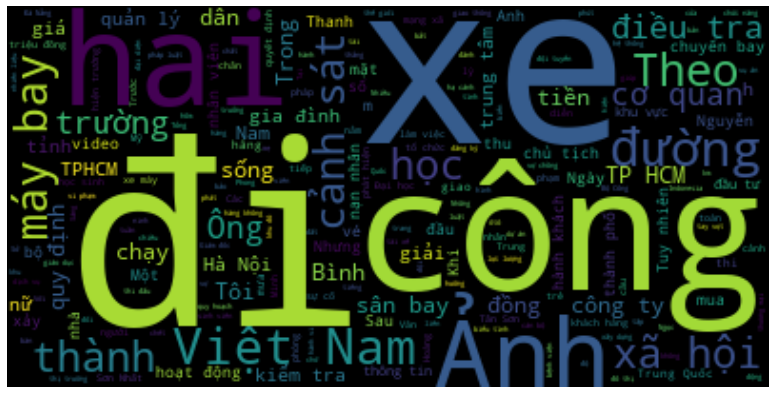

In [8]:
fake_news = news_df.loc[news_df['label'] == 0]
text = ' '.join(fake_news['text_reduced'].explode())

wordcloud = WordCloud().generate(text)

plt.figure(figsize=(20,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# III. Mô hình hóa

In [9]:
X_train = news_df['text_reduced'].str.join(' ')
y_train = news_df['label']
X_train, y_train

(0      Thủ tướng Abe cúi đầu xin lỗi hành động phi th...
 1      Thủ tướng Nhật cúi đầu xin lỗi tinh thần phi t...
 2      Choáng Cơ trưởng đeo khăn quàng quẩy banh sân ...
 3      Chưa nhạc Kpop hát Giáo sư Nguyễn Lân Dũng Con...
 4      Đại học Hutech áp dụng cải cách Tiếq Việt học ...
                              ...                        
 218    Siêu máy bay A chở CĐV Việt Nam đi Malaysia cổ...
 219    Thưởng USD đội tuyển cờ vua Việt Nam Olympiad ...
 220    Trường Sơn giành HCV giải cờ vua đồng đội thế ...
 221    Chuyện chàng sinh viên Luật Kiện tướng Lê Tuấn...
 222    Tiền đạo Malaysia Tôi hàng thủ đội tuyển Việt ...
 Name: text_reduced, Length: 223, dtype: object,
 0      1
 1      1
 2      1
 3      1
 4      1
       ..
 218    0
 219    0
 220    0
 221    0
 222    0
 Name: label, Length: 223, dtype: int64)

## 1. Mô hình 1

## 2. Mô hình 2

In [10]:
# ....code mô hình 2

# IV. Deploy mô hình

- Phần này sử dụng thư viện Streamlit và làm trong file `app.py`